In [2]:
## import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc4
import tarfile
import json
import uuid as uuid
import os
from datetime import datetime, timedelta
from pathlib import Path
import s3fs
import argparse
from pprint import pprint
import time 
import gzip
import traceback
from contextlib import contextmanager
import MITgcmutils

## import ECCO utils
import sys
sys.path.append('/Users/mzahn/github_others/ECCOv4-py')
import ecco_v4_py as ecco

In [4]:
## Define functions

def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

def time_it(func):
    """
    Decorator that reports the execution time.
    """
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Capture the start time
        result = func(*args, **kwargs)  # Execute the function
        end_time = time.time()  # Capture the end time
        print(f"{func.__name__} took {end_time-start_time:.4f} seconds to execute")
        return result
    return wrapper


def is_valid_gzip_file(filepath):
    try:
        # https://stackoverflow.com/questions/33938173/verifying-file-integrity-with-python/33938986#33938986
        # Attempt to open the gzip file in read mode
        with gzip.open(filepath, 'rb') as f:
             print(f'... opening {filepath}')
             # if the gz is bad then seek to the end will fail
             f.seek(-1, os.SEEK_END)
             return True

    except Exception as e:
        print(f'ERROR: caught for {filepath} {e}')
        traceback.print_exc()
        return False



def load_sassie_N1_field(file_dir, fname, nk=1, skip=0):
    num_cols = 680*4 + 1080
    num_rows = 1080
    
    time_level = int(fname.split('.data')[0].split('.')[-1])
    
    tmp_compact = ecco.load_binary_array(file_dir, fname, \
                                    num_rows, num_cols, nk=nk, skip=skip, 
                                    filetype='>f4', less_output=True)

    return tmp_compact, time_level


def sassie_n1_compact_to_faces_2D(sassie_n1_compact):
    sassie_faces = dict()
    n = 680
    
    # Face 1 
    start_row = 0
    end_row = n
    sassie_faces[1] = sassie_n1_compact[start_row:end_row,:]

    # Face 2
    start_row = end_row
    end_row = start_row + n

    sassie_faces[2] = sassie_n1_compact[start_row:end_row,:]
    
    # Face 3
    start_row = end_row
    end_row = start_row + 1080
    sassie_faces[3] = sassie_n1_compact[start_row:end_row:,:]
    
    #Face 4
    start_row = end_row
    end_row = end_row + 680
    sassie_faces[4] = sassie_n1_compact[start_row:end_row].reshape(1080, n)

    #Face 5
    start_row = end_row
    end_row = end_row + 680
    sassie_faces[5] = sassie_n1_compact[start_row:end_row].reshape(1080, n)

    return sassie_faces


def sassie_n1_compact_to_faces_3D(sassie_n1_compact):
    sassie_faces = dict()
    n = 680
    
    # Face 1 
    start_row = 0
    end_row = n
    sassie_faces[1] = sassie_n1_compact[:,start_row:end_row,:]

    # Face 2
    start_row = end_row
    end_row = start_row + n
    sassie_faces[2] = sassie_n1_compact[:,start_row:end_row,:]
    
    # Face 3
    start_row = end_row
    end_row = start_row + 1080
    sassie_faces[3] = sassie_n1_compact[:,start_row:end_row:,:]
    
    #Face 4
    start_row = end_row
    end_row = end_row + 680
    sassie_faces[4] = sassie_n1_compact[:,start_row:end_row].reshape(90, 1080, n)

    #Face 5
    start_row = end_row
    end_row = end_row + 680
    sassie_faces[5] = sassie_n1_compact[:,start_row:end_row].reshape(90, 1080, n)

    return sassie_faces


def combine_sassie_N1_faces_to_HHv2_2D(face_arr):
    """
    2D function for scalar fields, c point
    """
    # dimensions of the final Arctic HH field. 535+185+1080=1800
    new_arr = np.zeros((1080, 1800)) 
    
    # cut out sections we want and assign them to location on HH
    new_arr[:, 185:185 + 1080] = face_arr[3]
    
    # rotate Face 1 to line up with orientation of Face 3
    new_arr[:, 0:185] = np.flipud(face_arr[1][-185:,:].T) # flip and transpose
    
    new_arr[:, 185 + 1080:] = face_arr[4][:,:535]

    new_arr = np.rot90(new_arr,2) # rotate it 180 so Greenland/AK are on bottom
    return new_arr


def combine_sassie_N1_faces_to_HHv2_2D_u_point(face_arr_u, face_arr_v):
    """
    2D function for vector fields, u point
    """
    ## dimensions of the final Arctic HH field. 535+185+1080=1800
    new_arr = np.zeros((1080, 1800))
    
    ## add Arctic face (3)
    new_arr[:, 185:185+1080] = face_arr_u[3] # take entire Artic face
    
    ## add face 1 that will be flipped (must use v array)
    new_arr[:, 0:185] = np.flipud(face_arr_v[1][-185:,:].T)
        
    ## add part of face 4 (Alaska)
    new_arr[:, 185+1080:] = face_arr_u[4][:,:535]

    ## rotate by 90 deg twice to have Alaska on bottom left
    ## since it is vector field, have to multiply whole array by -1
    new_arr = np.rot90(new_arr,2)
    new_arr = new_arr *-1
        
    return new_arr


def combine_sassie_N1_faces_to_HHv2_2D_v_point(face_arr_v, face_arr_u, vec=False):
    """
    2D function for vector fields, v point
    """
    ## dimensions of the final Arctic HH field. 535+185+1080=1800
    new_arr = np.zeros((1080, 1800))
    
    ## add Arctic face (3)
    new_arr[:, 185:185+1080] = face_arr_v[3]
    
    ## add part of face 1 (Europe) that will be flipped (must use u array and multiply by -1)
    
    ## after rotating face 1, the u points on face 1 will not match the v points of face 3 (offset by 1 upwards)
    ## therefore, must remove the first column of face 1 and add the first column from face 2 to the end of face 1
    ## remove the first i column from the u field so the shape is (680, 1079) = (j,i)
    face1_tmp = face_arr_u[1][:,1:]
    ## then add the first row from face 2 to the end of face 1
    face1_mod = np.concatenate((face1_tmp, face_arr_u[2][:,:1]), axis=1)
    
    ## add modified face 1 by rotating and multiplying by -1
    new_arr[:, 0:185] = np.flipud(face1_mod[-185:,:].T)*-1
    
    ## add part of face 4 (Alaska)
    new_arr[:, 185+1080:] = face_arr_v[4][:,:535]

    ## rotate by 90 deg twice to have Alaska on bottom left
    new_arr = np.rot90(new_arr,2)
    new_arr = new_arr *-1
        
    return new_arr


def combine_sassie_N1_faces_to_HHv2_3D(face_arr):
    """
    3D function for scalar fields, c point
    """
    # dimensions of the final Arctic HH field. 535+185+1080=1800 ; 90 vertical levels
    new_arr = np.zeros((90, 1080, 1800)) 
    
    # cut out sections we want and assign them to location on HH
    new_arr[:,:,185:185+1080] = face_arr[3]
    
    # rotate Face 1 to line up with orientation of Face 3
    new_arr[:,:,0:185] = np.transpose(face_arr[1][:,-185:,::-1],axes=(0,2,1)) # flip and transpose
    
    ## add part of face 4 (Alaska)
    new_arr[:,:,185+1080:] = face_arr[4][:,:,:535]
    
    ## rotate it 180 so Greenland/AK are on bottom
    new_arr = np.rot90(new_arr,2,axes=(1,2)) 
    
    return new_arr


def combine_sassie_N1_faces_to_HHv2_3D_u_point(face_arr_u, face_arr_v):
    """
    3D function for vector fields, u point
    """
    ## dimensions of the final Arctic HH field. 535+185+1080=1800 ; 90 vertical levels
    new_arr = np.zeros((90, 1080, 1800))
    
    ## add Arctic face (3)
    new_arr[:,:,185:185+1080] = face_arr_u[3] # take entire Artic face
    
    ## add face 1 that will be flipped (must use v array)
    new_arr[:,:,0:185] = np.transpose(face_arr_v[1][:,-185:,::-1],axes=(0,2,1))
        
    ## add part of face 4 (Alaska)
    new_arr[:,:,185+1080:] = face_arr_u[4][:,:,:535]

    ## rotate by 90 deg twice to have Alaska on bottom left
    ## since it is vector field, have to multiply whole array by -1
    new_arr = np.rot90(new_arr,2,axes=(1,2))
    new_arr = new_arr *-1
        
    return new_arr


def combine_sassie_N1_faces_to_HHv2_3D_v_point(face_arr_v, face_arr_u):
    """
    3D function for vector fields, v point
    """
    ## dimensions of the final Arctic HH field. 535+185+1080=1800
    new_arr = np.zeros((90, 1080, 1800))
    
    ## add Arctic face (3)
    new_arr[:,:,185:185+1080] = face_arr_v[3]
    
    ## add part of face 1 (Europe) that will be flipped (must use u array and multiply by -1)
    
    ## after rotating face 1, the u points on face 1 will not match the v points of face 3 (offset by 1 upwards)
    ## therefore, must remove the first column of face 1 and add the first column from face 2 to the end of face 1
    ## remove the first i column from the u field so the shape is (680, 1079) = (j,i)
    face1_tmp = face_arr_u[1][:,:,1:]
    ## then add the first row from face 2 to the end of face 1
    face1_mod = np.concatenate((face1_tmp, face_arr_u[2][:,:,:1]), axis=2)
    
    ## add modified face 1 by rotating and multiplying by -1
    new_arr[:,:,0:185] = np.transpose(face1_mod[:,-185:,::-1],axes=(0,2,1))*-1
    
    ## add part of face 4 (Alaska)
    new_arr[:,:,185+1080:] = face_arr_v[4][:,:,:535]

    ## rotate by 90 deg twice to have Alaska on bottom left
    new_arr = np.rot90(new_arr,2,axes=(1,2))
    new_arr = new_arr *-1
        
    return new_arr


def timestamp_from_iter_num(iter_num):
    """
    takes the model iteration that was pulled from the data's filename and converts it to its equivalent datetime
    """
    ## Start time of the model is 5790000 (22.0319 years after 1992-01-01)
    ## there are 120 seconds for each iteration and 86400 seconds per day
    ## take the iteration number, convert to seconds, and calculate number of days since start of model
    
    ## from Mike: "Near the end of the simulation, I ran into some sort of instability so I changed the time step from 120 seconds to 60 seconds.
    ## Usually I would change it back to 120 second after getting past the instability but I was kinda close to the end so I just let it ride with 60 seconds."
    if iter_num > 1e7:
        iter_num = iter_num/2
    
    num_days_since_start = iter_num*120 / 86400 ## divide iter_number by 86400 which is equal to the number of seconds in a day
    
    model_start_time = datetime(1992,1,1) # data.cal start time is 1992-01-01
    timestamp = np.array([model_start_time + timedelta(days=num_days_since_start)], dtype='datetime64[ns]')
    
    return timestamp

def unpack_tar_gz_files(data_dir, keep_local_files):
    ## see if tar.gz files were already decompressed
    print(f'... looking for *.data files in {data_dir}')
    data_files = list(data_dir.glob('*.data'))

    if len(data_files)>0:
        print("... tar.gz files already unpacked")

    ## if not, open them
    else:
        ## pull list of all tar.gz files in directory
        tar_gz_files = list(data_dir.glob('*.tar.gz'))
        
        ## unzip targz file
        for file_path in tar_gz_files:
            print(f'... testing validity of {file_path}')

            if is_valid_gzip_file(file_path):
              try:
                 tar = tarfile.open(file_path, "r:gz")
                 tar.extractall(data_dir) # save files to same directory
                 tar.close()
              except Exception as e:
                 print(f'ERROR: could not extractall {file_path}')

            else:
              print('ERROR: invalid gz file could not open {file_path}')
             


def show_me_the_ds(ds):
    print('\n>>show_me_the_ds')
    print('dims: ', list(ds.dims))
    print('coords: ', list(ds.coords))
    print('data_vars: ', list(ds.data_vars))

def show_me_the_da(da):
    print('\n>>show_me_the_da')
    print('dims: ', list(da.dims))
    print('coords: ',list(da.coords))
    
def make_2D_HHv2_ds(field_HH, model_grid_ds, timestamp, grid_point, da_name):
    
    ## get time bounds and center time
    time_bnds, center_time = ecco.make_time_bounds_from_ds64(timestamp[0], 'AVG_DAY')
    time_bnds_da = xr.DataArray(time_bnds.reshape(1,2), dims=['time', 'nv'])
    
    ## create DataArray for c point data
    if grid_point == 'c':
        tmp_da = xr.DataArray([field_HH], dims=['time','j','i'],\
                                coords={'time':(('time'), np.array([center_time]))})
    
    ## create DataArray for u point data
    elif grid_point == 'u':
        tmp_da = xr.DataArray([field_HH], dims=['time','j','i_g'],\
                                coords={'time':(('time'), np.array([center_time]))})
    
    ## create DataArray for v point data
    elif grid_point == 'v':
        tmp_da = xr.DataArray([field_HH], dims=['time','j_g','i'],\
                                coords={'time':(('time'), np.array([center_time]))})
    
    ## name the array
    tmp_da.name = da_name
    
    ## add additional coordinates to dataset
    tmp_ds = tmp_da.to_dataset().assign_coords({
        'time_bnds':time_bnds_da,\
        'XC':model_grid_ds.XC,\
        'YC':model_grid_ds.YC,\
        'XG':model_grid_ds.XG,\
        'YG':model_grid_ds.YG,\
        'XC_bnds':model_grid_ds.XC_bnds,\
        'YC_bnds':model_grid_ds.YC_bnds})
    
    return tmp_ds


def make_3D_HHv2_ds(field_HH, model_grid_ds, timestamp, grid_point, da_name, k_face='center'):
    
    ## get time bounds and center time
    time_bnds, center_time = ecco.make_time_bounds_from_ds64(timestamp[0], 'AVG_DAY')
    time_bnds_da = xr.DataArray(time_bnds.reshape(1,2), dims=['time', 'nv'])
    
    if k_face == 'center':
        
        ## create DataArray for c point data, center
        if grid_point == 'c':
            tmp_da = xr.DataArray([field_HH], dims=['time', 'k','j','i'],\
                                    coords={'time':(('time'),np.array([center_time]))})
            tmp_da['k'].attrs['axis']  = 'Z'
            
        ## create DataArray for u point data, center
        elif grid_point == 'u':
            tmp_da = xr.DataArray([field_HH], dims=['time', 'k','j','i_g'],\
                                    coords={'time':(('time'),np.array([center_time]))})
            tmp_da['k'].attrs['axis']  = 'Z'
            
        ## create DataArray for v point data, center
        elif grid_point == 'v':
            tmp_da = xr.DataArray([field_HH], dims=['time', 'k','j_g','i'],\
                                    coords={'time':(('time'),np.array([center_time]))})
            tmp_da['k'].attrs['axis']  = 'Z'            
            
    elif k_face == 'top':
        ## create DataArray for c point data, top
        tmp_da = xr.DataArray([field_HH], dims=['time','k_l','j','i'],\
                                coords={'time':(('time'),np.array([center_time]))})
        tmp_da['k_l'].attrs['axis']  = 'Z'

    ## name the array
    tmp_da.name = da_name
        
    ## add additional coordinates to dataset
    tmp_ds = tmp_da.to_dataset().assign_coords({
        'time_bnds':time_bnds_da,\
        'XC':model_grid_ds.XC,\
        'YC':model_grid_ds.YC,\
        'XG':model_grid_ds.XG,\
        'YG':model_grid_ds.YG,\
        'XC_bnds':model_grid_ds.XC_bnds,\
        'YC_bnds':model_grid_ds.YC_bnds,\
        'Z':model_grid_ds.Z,\
        'Zu':model_grid_ds.Zu,\
        'Zl':model_grid_ds.Zl,\
        'Zp1':model_grid_ds.Zp1})
        
 #   tmp_da = add_geo_metadata(tmp_da)

    return tmp_ds


def process_2D_variable(data_dir, filename, fldList_index, var_tmp_table, vars_table, sassie_n1_geometry_ds):
    
    var_name = var_tmp_table['variable'].values[0]
    n_skip = fldList_index * 1
    grid_point = var_tmp_table.cgrid_point.values
    
    ## process binary data to compact format
    data_compact, iter_num = load_sassie_N1_field(str(data_dir), filename, nk=1, skip=n_skip)
    
    ## convert compact format to 5 faces
    data_faces = sassie_n1_compact_to_faces_2D(data_compact)
    
    ## convert faces to HHv2 Arctic rectangle
    ## data on u and v points need to be handled differently from c points
    if var_tmp_table.data_type.values == 'V': # if it is a vector field
        var_mate = var_tmp_table.mate.values[0]
        var_table_mate = vars_table[vars_table.variable.values == var_mate]
        var_mate_field_index = var_table_mate.field_index.values[0]
        
        if grid_point == 'v':
            ## get u field
            n_skip_u = var_mate_field_index
            data_compact_u, iter_num = load_sassie_N1_field(str(data_dir), filename, nk=1, skip=n_skip_u)
            face_arr_u = sassie_n1_compact_to_faces_2D(data_compact_u)
            
            ## process v field
            var_HHv2 = combine_sassie_N1_faces_to_HHv2_2D_v_point(data_faces, face_arr_u)
            
        elif grid_point == 'u':
            ## get v field
            n_skip_v = var_mate_field_index
            data_compact_v, iter_num = load_sassie_N1_field(str(data_dir), filename, nk=1, skip=n_skip_v)
            face_arr_v = sassie_n1_compact_to_faces_2D(data_compact_v)
            
            ## process u field
            var_HHv2 = combine_sassie_N1_faces_to_HHv2_2D_u_point(data_faces, face_arr_v)
            
    elif var_tmp_table.data_type.values == 'S': # if it is a scalar field
        var_HHv2 = combine_sassie_N1_faces_to_HHv2_2D(data_faces)
    
    ## add timestamp adn create dataset
    timestamp = timestamp_from_iter_num(iter_num)
    var_HHv2_ds = make_2D_HHv2_ds(var_HHv2, sassie_n1_geometry_ds, timestamp, grid_point=grid_point, da_name=var_name)

    return var_HHv2_ds


def process_3D_variable(data_dir, filename, fldList_index, var_tmp_table, vars_table, sassie_n1_geometry_ds):
    
    var_name = var_tmp_table['variable'].values[0]
    
    ## there are 90 vertical levels; use index from table to identify how many fields to skip
    n_skip = fldList_index * 90
    var_k_face = var_tmp_table['k_face'].values[0]
    grid_point = var_tmp_table.cgrid_point.values
    
    ## process binary data to compact format
    data_compact, iter_num = load_sassie_N1_field(str(data_dir), filename, nk=90, skip=n_skip)
    
    ## convert compact format to 5 faces
    data_faces = sassie_n1_compact_to_faces_3D(data_compact)
    
    ## convert faces to HHv2 Arctic rectangle
    ## data on u and v points need to be handled differently from c points
    if var_tmp_table.data_type.values == 'V': # if it is a vector field
        var_mate = var_tmp_table.mate.values[0]
        var_table_mate = vars_table[vars_table.variable.values == var_mate]
        var_mate_field_index = var_table_mate.field_index.values[0]
        
        if grid_point == 'v':
            ## get u field
            n_skip_u = var_mate_field_index * 90
            data_compact_u, iter_num = load_sassie_N1_field(str(data_dir), filename, nk=90, skip=n_skip_u)
            face_arr_u = sassie_n1_compact_to_faces_3D(data_compact_u)
            
            ## process v field
            var_HHv2 = combine_sassie_N1_faces_to_HHv2_3D_v_point(data_faces, face_arr_u)
            
        elif grid_point == 'u':
            ## get v field
            n_skip_v = var_mate_field_index * 90
            data_compact_v, iter_num = load_sassie_N1_field(str(data_dir), filename, nk=90, skip=n_skip_v)
            face_arr_v = sassie_n1_compact_to_faces_3D(data_compact_v)
            
            ## process u field
            var_HHv2 = combine_sassie_N1_faces_to_HHv2_3D_u_point(data_faces, face_arr_v)
        
    elif var_tmp_table.data_type.values == 'S': # if it is a scalar field
        var_HHv2 = combine_sassie_N1_faces_to_HHv2_3D(data_faces) # c point
    
    ## add timestamp and create dataset
    timestamp = timestamp_from_iter_num(iter_num)
    var_HHv2_ds = make_3D_HHv2_ds(var_HHv2, sassie_n1_geometry_ds, timestamp, grid_point=grid_point, da_name=var_name, k_face=var_k_face)
    
    return var_HHv2_ds


def mask_dry_grid_cells(ds, var, geometry_ds, grid_point):
    # .. I do not see why we need to copy the dataset instead of operating on it directly
    ## make copy of dataset
    #ds_tmp = ds.copy(deep=True)
 
    ## tracer points use maskC, u points use maskW, and v points use maskS
    if grid_point == 'c':
        # some 3D vertical vector fields (like WVEL) 
        # use 'k_l' for their vertical dimension  
        # to apply the wet/dry mask using maskC,
        # we first have to temporarily rename the maskC 
        # vertical dimension from k to k_l 
        if 'k_l' in ds[var].dims:
            ds[var] = ds[var].where(geometry_ds.maskC.rename({'k':'k_l'}) == True)
        else: 
            ds[var] = ds[var].where(geometry_ds.maskC==True)
        
    elif grid_point == 'v':
        ds[var] = ds[var].where(geometry_ds.maskS==True)
        
    elif grid_point == 'u':
        ds[var] = ds[var].where(geometry_ds.maskW==True)
    
    return ds


def create_encoding(ecco_ds, output_array_precision = np.float32):
    
    # Create NetCDF encoding directives
    # ---------------------------------------------
    # print('\n... creating variable encodings')
    # ... data variable encoding directives
    
    # Define fill values for NaN
    if output_array_precision == np.float32:
        netcdf_fill_value = nc4.default_fillvals['f4']

    elif output_array_precision == np.float64:
        netcdf_fill_value = nc4.default_fillvals['f8']
    
    dv_encoding = dict()
    for dv in ecco_ds.data_vars:
        dv_encoding[dv] =  {'compression':'zlib',\
                            'complevel':5,\
                            'shuffle':False,\
                            'fletcher32': False,\
                            '_FillValue':netcdf_fill_value}

    # ... coordinate encoding directives
    coord_encoding = dict()
    
    for coord in ecco_ds.coords:
        # set default no fill value for coordinate
        if output_array_precision == np.float32:
            coord_encoding[coord] = {'_FillValue':None, 'dtype':'float32'}
        elif output_array_precision == np.float64:
            coord_encoding[coord] = {'_FillValue':None, 'dtype':'float64'}

        # force 64 bit ints to be 32 bit ints
        if (ecco_ds[coord].values.dtype == np.int32) or \
           (ecco_ds[coord].values.dtype == np.int64) :
            coord_encoding[coord]['dtype'] ='int32'

        # fix encoding of time
        if coord == 'time' or coord == 'time_bnds':
            coord_encoding[coord]['dtype'] ='int32'

            if 'units' in ecco_ds[coord].attrs:
                # apply units as encoding for time
                coord_encoding[coord]['units'] = ecco_ds[coord].attrs['units']
                # delete from the attributes list
                del ecco_ds[coord].attrs['units']

        elif coord == 'time_step':
            coord_encoding[coord]['dtype'] ='int32'

    # ... combined data variable and coordinate encoding directives
    encoding = {**dv_encoding, **coord_encoding}

    return encoding


def modify_metadata(ds, var, var_filename_netcdf):   
    title = 'SASSIE Ocean Model ' + var + ' Parameter for the Lat-Lon-Cap 1080 (llc1080) Native Model Grid (Version 1 Release 1)'
  
    ## edit specific metadata for these datasets
    ds.attrs['author'] = 'Mike Wood, Marie Zahn, and Ian Fenty'
    ds.attrs['comment'] = 'SASSIE llc1080 V1R1 fields are consolidated onto a single curvilinear grid face focusing on the Arctic domain using fields from the 5 faces of the lat-lon-cap 1080 (llc1080) native grid used in the original simulation.'
    ds.attrs['id'] = '10.5067/XXXXX-XXXXX' # will update with DOI when avail

    if 'k' in list(ds.dims):
        ds.attrs['geospatial_vertical_min'] = np.round(ds.Zu.min().values,1)
        
    ds.attrs['geospatial_lat_min'] = np.round(ds.YC.min().values,1)
    ds.attrs['metadata_link'] = 'https://cmr.earthdata.nasa.gov/search/collections.umm_json?ShortName=TBD' # will update with DOI when avail
    ds.attrs['product_name'] = var_filename_netcdf
    ds.attrs['time_coverage_end'] = str(ds.time_bnds.values[0][0])[:-10]
    ds.attrs['time_coverage_start'] = str(ds.time_bnds.values[0][1])[:-10]
    ds.attrs['product_version'] = 'Version 1, Release 1'
    ds.attrs['program'] = 'NASA Physical Oceanography'
    ds.attrs['source'] = 'The SASSIE ocean model simulation was produced by downscaling the global ECCO state estimate from 1/3 to 1/12 degree grid cells. The ECCO global solution provided initial and boundary conditions and atmospheric forcing.'
    ds.attrs['references'] = 'TBD'
    ds.attrs['summary'] = 'This dataset provides data variable and geometric parameters for the lat-lon-cap 1080 (llc1080) native model grid from the SASSIE ECCO ocean model Version 1 Release 1 (V1r1) ocean and sea-ice state estimate.'
    ds.attrs['title'] = title
    ds.attrs['uuid'] = str(uuid.uuid1())
    ds.attrs['history'] ='Initial release of the ECCO N1 Sassie Ocean-Sea Ice Simulation'
    
    ## remove some attributes we don't need
    attributes_to_remove = ['product_time_coverage_start', 'product_time_coverage_end',\
                            'geospatial_lat_resolution', 'geospatial_lon_resolution']
    
    ## add current time and date
    current_time = datetime.now().isoformat()[0:19]
    ds.attrs['date_created'] = current_time
    ds.attrs['date_modified'] = current_time
    ds.attrs['date_metadata_modified'] = current_time
    ds.attrs['date_issued'] = current_time
    
    for attr in attributes_to_remove:
        ds.attrs.pop(attr, None)
        
    return ds


def reorder_dims(xr_dataset):
    ## specify order of dims

    # if 3D
    if 'k' in list(xr_dataset.dims):
        #tmp = xr_dataset[["time","j","i","k","j_g","i_g","k_u","k_l","k_p1","nv","nb"]]
        tmp = xr_dataset[["time","k","j","i","k_u","k_l","k_p1","nv"]]
    # if 2D
    else:
        tmp = xr_dataset[["time","j","i","nv"]]

    tmp = tmp.drop_indexes(["nv"]).reset_coords(["nv"], drop=True)
    

    ## reassign dataset to new dims
    xr_ds_ordered = tmp.assign(xr_dataset)
    
    return xr_ds_ordered



# def push_nc_dir_to_ec2(nc_root_dir_ec2, root_dest_s3_name):
#     """
#     Pushes the netcdf files from a directory to an S3 bucket.

#     Args:
#         nc_root_dir_ec2 (str): The root directory containing the netcdf files on the EC2 instance.
#         root_dest_s3_name (str): The root name of the S3 bucket where the files will be pushed.

#     Returns:
#         None
#     """
#     ## upload each subdirectory in the nc root directory
    
#     # Get a list of all items (files and folders) in the directory
#     all_subdirs = os.listdir(nc_root_dir_ec2)

#     for subdir_name in all_subdirs:
#         if subdir != '.ipynb_checkpoints':
#             print(subdir)
            
            
#             ## push file to s3 bucket
#             mybucket = root_dest_s3_name + subdir_name
#             subdir_fullpath = Path(nc_root_dir_ec2 / subdir_name)
#             nc_files = list(subdir_fullpath.glob('*.nc'))
    
#             print(f'\n>pushing netcdf files in {subdir_name} to s3 bucket : {mybucket}')
#             print(f'... looking for *.nc files in {subdir_name}')
#             print(f'... found {len(nc_files)} nc files to upload')
    
#             if len(nc_files)>0:
#                 cmd=f"aws s3 cp {subdir_fullpath} {mybucket}/ --recursive --include '*.nc' --no-progress > /dev/null 2>&1"
#                 print(f'... aws command: {cmd}')
#                 with suppress_stdout():
#                    os.system(cmd)
#             else:
#                 print("... nothing to upload!") 
            
#         else:
#             print(f"No subdirectories found in {nc_root_dir_ec2}")


def save_sassie_netcdf_to_ec2(var_HHv2_ds, nc_dir_ec2, var_filename_netcdf):
    ## save netCDF files to disk and then push to s3 bucket

    # var_HHv2_ds         : The xarray dataset that will be saved to netcdf
    # nc_dir_ec2          : The directory where the netcdf file will be saved on the ec2 instance
    # var_filename_netcdf : The name of the netcdf file that will be saved
    
    ## create encoding
    encoding_var = create_encoding(var_HHv2_ds, output_array_precision = np.float32)
    
    ## stage netcdf on tmp directory on ec2
    tmp_netcdf_filename = str(nc_dir_ec2) + "/" + var_filename_netcdf

    print('   saving netcdf to ', tmp_netcdf_filename)
    var_HHv2_ds.to_netcdf(str(tmp_netcdf_filename), encoding = encoding_var)
    var_HHv2_ds.close()
        

def create_HH_netcdfs(data_filename, data_dir_ec2, nc_root_dir_ec2, metadata_dict, sassie_n1_geometry_ds, vars_table, save_nc_to_disk):
    """
    Create netCDF files for all variables in a given file.

    Args:
        data_filename (str): The name *.data filename.
        data_dir_ec2 (str): The directory containing the data files.
        nc_root_dir_ec2 (str): The root directory where all netCDF files are saved.
        metadata_dict (dict): A dictionary containing metadata information.
        sassie_n1_geometry_ds (Dataset): The dataset containing geometry information.
        vars_table (DataFrame): A table containing variable information.

    Returns:
        None
    """
    
    ## loop through each variable that was requested --------------------------------------------
    
    print('\n############ processing:', data_filename, '############')
    
    ## identify variables in this dataset
    meta_file_path = str(data_dir_ec2) + "/" + data_filename[:-5] + ".meta"
    meta_file_dict = MITgcmutils.mds.parsemeta(meta_file_path)
    vars_in_dataset = meta_file_dict['fldList']
    
    for i in range(len(vars_in_dataset)):
        
        var_name = vars_in_dataset[i]
        fldList_index = i
        
        # ## create directory for variable
        # nc_dir_ec2 = nc_root_dir_ec2 + "/" + var_name + "_AVG_DAILY"
        # try:
        #     os.mkdir(nc_dir_ec2, exist_ok=True, parents=True)
        # except :
        #     print(f"ERROR: could not make {nc_dir_ec2} ")
        #     exit()
            
        nc_dir_ec2 = "/Users/mzahn/data/SASSIE/SASSIE_netcdfs/ocean_state_3D_day_mean/" + var_name + "_AVG_DAILY"
        
        ## get variable data from table
        var_tmp_table = vars_table[vars_table.variable.isin([var_name])]
        print('>> processing: ', var_name)
        
        ## 3D data processing
        if var_tmp_table['n_dims'].values == '3D':
            ## process dataset
            var_HHv2_ds = process_3D_variable(data_dir_ec2, data_filename, fldList_index, var_tmp_table,\
                                              vars_table, sassie_n1_geometry_ds)
                
            #print('\nds after 3d loading')
            #show_me_the_ds(var_HHv2_ds)

            ## mask land cells
            var_HHv2_ds = mask_dry_grid_cells(var_HHv2_ds, var_name, sassie_n1_geometry_ds, \
                                              grid_point=var_tmp_table['cgrid_point'].values)
            #print('\nds after 3d masking:')

        ## 2D data processing 
        elif var_tmp_table['n_dims'].values == '2D':
            ## process dataset
            var_HHv2_ds = process_2D_variable(data_dir_ec2, data_filename, fldList_index, var_tmp_table,\
                                              vars_table, sassie_n1_geometry_ds)
            #print('\nds after 2d loading')
            #show_me_the_ds(var_HHv2_ds)

            ## mask land cells
            # select out the k=0 level of the geometry dataset
            var_HHv2_ds = mask_dry_grid_cells(var_HHv2_ds, var_name, sassie_n1_geometry_ds.isel(k=0), \
                                              grid_point=var_tmp_table['cgrid_point'].values)
            
            # 2D datasets have neither k dims nor Z coordinates
            var_HHv2_ds = var_HHv2_ds.drop_vars(['k','Z'])
            #print('\nds after 2d masking:')
            #show_me_the_ds(var_HHv2_ds)

        # drop grid cell corner dims and coordinates
        var_HHv2_ds = var_HHv2_ds.drop_vars(['i_g','j_g','XG','YG','XC_bnds','YC_bnds'])

        ## add metadata
        global_latlon_metadata = metadata_dict['ECCOv4r4_global_metadata_for_all_datasets'] + metadata_dict['ECCOv4r4_global_metadata_for_latlon_datasets']
        var_HHv2_ds = ecco.add_global_metadata(global_latlon_metadata, var_HHv2_ds, var_tmp_table['n_dims'].values[0])
        var_HHv2_ds = ecco.add_coordinate_metadata(metadata_dict['ECCOv4r4_coordinate_metadata_for_latlon_datasets'], var_HHv2_ds, less_output=True)
        var_HHv2_ds, grouping_keywords = ecco.add_variable_metadata(metadata_dict['ECCOv4r4_geometry_metadata_for_latlon_datasets'], var_HHv2_ds, less_output=True)
        var_HHv2_ds, grouping_keywords = ecco.add_variable_metadata(metadata_dict['ECCOv4r4_variable_metadata'], var_HHv2_ds, less_output=True)
        
        ## generate filename
        center_time = var_HHv2_ds.time.values
        yyyy_mm_dd = str(center_time)[2:6] + "-" + str(center_time)[7:9] + "-" + str(center_time)[10:12]
        var_filename_netcdf = var_name + "_day_mean_" + yyyy_mm_dd + "_ECCO_SASSIE_V1_HH_llc1080.nc"
        
        ## tweak some of the global attributes
        var_HHv2_ds = modify_metadata(var_HHv2_ds, var_name, var_filename_netcdf)
        
        ## reorder dims
        var_HHv2_ds = reorder_dims(var_HHv2_ds)
        
        #data_dir_ec2
        ## save netcdf
        if save_nc_to_disk:
            save_sassie_netcdf_to_ec2(var_HHv2_ds, nc_dir_ec2, var_filename_netcdf)
        
        # remove from memory
        var_HHv2_ds = None

    # return(var_HHv2_ds_final)
    print("######## processing complete ########\n")

In [12]:
########### Create final routine to process files ########### 

## Specify root directory and process all variables in that dataset

def generate_sassie_ecco_netcdfs(root_filenames, root_s3_name, root_dest_s3_name, 
                                 force_redownload, keep_local_files, push_to_s3,
                                 files_to_process, local_scratch_dir, save_nc_to_disk):
    

    # ## get list of gz files in s3 directory
    # s3 = []
    # s3 = s3fs.S3FileSystem(anon=False)
        
    ## --------------------------------------------
    ## open model geometry from ec2

#     n1_geometry_local_dir =  Path('/home/jpluser/sassie/N1/GRID_GEOMETRY')
#     n1_geometry_local_filename = 'GRID_GEOMETRY_SASSIE_HH_V1R1_NATIVE_LLC1080.nc'
#     n1_geometry_local_full_path = n1_geometry_local_dir / n1_geometry_local_filename
#     n1_geometry_s3_url = 's3://ecco-processed-data/SASSIE/N1/V1/HH/NETCDF/GRID/GRID_GEOMETRY_SASSIE_HH_V1R1_NATIVE_LLC1080.nc'

#     print('> loading geometry dataset')
#     if not n1_geometry_local_full_path.is_file(): # checks if file is there
#         # make geometry directory
#         try:
#             print(f"...creating geometry directory {n1_geometry_local_dir}")
#             n1_geometry_local_dir.mkdir(exist_ok=False, parents=True)
#         except FileExistsError:
#             print(f"...directory {n1_geometry_local_dir} already exists")

#         # download geometry file
#         try:
#             s3.download(n1_geometry_s3_url, str(n1_geometry_local_full_path))
#             print(f"...downloaded {n1_geometry_s3_url} to {n1_geometry_local_full_path}")
#         except:
#             print(f"ERROR: could not download {n1_geometry_s3_url} to {n1_geometry_local_full_path}")
#             return
    
    n1_geometry_local_full_path = "/Users/mzahn/data/SASSIE/GRID_GEOMETRY_SASSIE_HH_V1R1_NATIVE_LLC1080.nc"
    
    sassie_n1_geometry_ds = xr.open_dataset(n1_geometry_local_full_path)
    sassie_n1_geometry_ds.close()
    print('... geometry file loaded')
    
    ## open table that includes metadata for all variables
    vars_table = pd.read_csv('/Users/mzahn/github/SASSIE_downscale_ecco_v5/sassie_variables_table.csv', index_col=False)
    
    ## --------------------------------------------
    ## load metadata 
    metadata_json_dir = "/Users/mzahn/github_others/ECCO-GROUP/ECCO-ACCESS/metadata/ECCOv4r4_metadata_json/"
    
    metadata_fields = ['ECCOv4r4_global_metadata_for_all_datasets',
                       'ECCOv4r4_global_metadata_for_latlon_datasets',
                       'ECCOv4r4_global_metadata_for_native_datasets',
                       'ECCOv4r4_coordinate_metadata_for_1D_datasets',
                       'ECCOv4r4_coordinate_metadata_for_latlon_datasets',
                       'ECCOv4r4_coordinate_metadata_for_native_datasets',
                       'ECCOv4r4_geometry_metadata_for_latlon_datasets',
                       'ECCOv4r4_geometry_metadata_for_native_datasets',
                       'ECCOv4r4_groupings_for_1D_datasets',
                       'ECCOv4r4_groupings_for_latlon_datasets',
                       'ECCOv4r4_groupings_for_native_datasets',
                       'ECCOv4r4_variable_metadata',
                       'ECCOv4r4_variable_metadata_for_latlon_datasets',
                       'ECCOv4r4_dataset_summary']
    
    ## load metadata
    metadata_dict = dict()
    
    for mf in metadata_fields:
        mf_e = mf + '.json'
        # print(mf_e)
        with open(Path(metadata_json_dir + mf_e), 'r') as fp:
            metadata_dict[mf] = json.load(fp)
    
    ## --------------------------------------------
    ## loop through gz files in root directory and process all variables included in the dataset
    
    # find filenames
    # file_list = np.sort(s3.glob(f'{root_s3_name}{root_filenames}/*tar.gz'))
    gz_dir_ec2 = Path("/Users/mzahn/data/SASSIE/SASSIE_examples/daily_avg/ocean_state_3D_day_mean/test/ocean_state_3D_day_mean.0005790000.tar.gz")
    file_list = np.sort(gz_dir_ec2.glob('*tar.gz'))

    print(f'\n> Looking for files on {root_s3_name}{root_filenames}')
    print(f'... num files  : {len(file_list)}')
    print(f'... first file : {file_list[0]}')
    print(f'... last file  : {file_list[-1]}')
      
#     # construct url form of filenames
#     data_urls = ['s3://' + f for f in file_list ]

#     print(f'\n> Preparing list of files to process')
#     ## specify start and end indices or process all files   
#     if len(files_to_process) == 2: # two numbers indicates a range (two indices)
#         data_urls_select = data_urls[files_to_process[0]:files_to_process[1]]
#         print(f'... first file to process : {data_urls_select[0]}')
#         print(f'... last file to process  : {data_urls_select[-1]}')
    
#     elif len(files_to_process) == 1 and files_to_process[0] == -1: # process all files
#         data_urls_select = data_urls
#         print(f'... first file to process : {data_urls_select[0]}')
#         print(f'... last file to process  : {data_urls_select[-1]}')
    
#     elif len(files_to_process) == 1 and files_to_process[0] >= 0: # process one file using number as index
#         # wrap in list
#         data_urls_select = [data_urls[files_to_process[0]]]
#         print(f'... 1 file to process : {data_urls_select}')
    
#     else:
#         print("ERROR: invalid entry for `files_to_process` argument")
#         return 
 

#     # Loop through all data_urls
#     for data_url in data_urls_select:
        
#         ## download tar.gz file from s3 cloud to ec2 tmp_dir
#         gz_filename = data_url.split("/")[-1]

#         print(f'\n==== processing file: {gz_filename} ====')
#         gz_tmp_dir_base = f"{gz_filename.split('.')[0]}_{gz_filename.split('.')[1]}"

#         gz_dir_ec2 =  Path(f"{local_scratch_dir}/tmp_gz/{gz_tmp_dir_base}")
#         nc_root_dir_ec2 =  Path(f"{local_scratch_dir}/tmp_nc/{gz_tmp_dir_base}")

#         print(f'... temporary gz directory {gz_dir_ec2}')
#         print(f'... temporary nc directory {nc_root_dir_ec2}')

#         gz_dir_ec2.mkdir(exist_ok=True, parents=True)
#         nc_root_dir_ec2.mkdir(exist_ok=True, parents=True)

#         gz_full_path = gz_dir_ec2 / gz_filename

#         print('\n> preparing *data file for processing')
#         print(f'... gz file: {gz_full_path}')
       
 
#         # download gz file
#         if (not gz_full_path.is_file()) or (force_redownload): # checks if file is there
#             start_time_a = time.time()
#             print(f'... gz file needs to be downloaded: isfile()={gz_full_path.is_file()} or force_redownload: {force_redownload}')
#             s3.download(data_url, str(gz_full_path))
#             print('... download time ', time.time() - start_time_a)
#         else: 
#             print(f'... not re-downloading gz because local gz is present: isfile()={gz_full_path.is_file()}')
            
        ## decompress tar.gz file into *.data and *.meta files
        unpack_tar_gz_files(gz_dir_ec2, keep_local_files)
    
        ## loop through each *.data file stored in the gz_dir_ec2 directory and process all variables within it
        ## create DataSets for each variable type within the *.data files
        ## and possibly store to disk if 'save_nc_to_disk==True'
        data_files = np.sort(list(gz_dir_ec2.glob('*.data')))
        
        if len(data_files) == 0:
           print('... no data files to process in {data_dir_ec2}')   
           return
        else:
           print(f'found {len(data_files)} *.data files in {gz_dir_ec2}')  
        
        for data_file in data_files:
            
            ## process all variables in the dataset stored in the gz_dir_ec2 directory
            create_HH_netcdfs(data_file, gz_dir_ec2, nc_root_dir_ec2, metadata_dict, sassie_n1_geometry_ds, vars_table, save_nc_to_disk)
        
        ## after processing is complete, delete data files on ec2
        ## push nc files to aws s3
        if push_to_s3:
            push_nc_dir_to_ec2(nc_root_dir_ec2, root_dest_s3_name)
        else:
            print('> not pushing files to s3')
    
        print('\n> cleaning up local nc files') 
        if keep_local_files:
            print('... keeping local nc  directories')
        else:
            ## remove tmp nc var directory and all of its contents
            print("... removing tmp nc dir ", nc_dir_ec2)
            os.system(f"rm -rf {nc_dir_ec2}")
        
        
        print('\n> cleaning up local gz directories')
        if keep_local_files:
            print('... keeping local gz directories')
        else:
            ## remove tmp tar.gz files
            print("... removing tmp gz dir")
            os.system(f"rm -rf {str(gz_dir_ec2)}")

            print("... removing tmp nc root dir ", nc_root_dir_ec2)
            os.system(f"rm -rf {str(nc_root_dir_ec2)}")

        print(f'\n==== done processing file: {gz_filename} ====\n')

IndentationError: unexpected indent (1871099031.py, line 148)

In [22]:
n1_geometry_local_full_path = "/Users/mzahn/data/SASSIE/GRID_GEOMETRY_SASSIE_HH_V1R1_NATIVE_LLC1080.nc"

sassie_n1_geometry_ds = xr.open_dataset(n1_geometry_local_full_path)
sassie_n1_geometry_ds.close()
print('... geometry file loaded')

## open table that includes metadata for all variables
vars_table = pd.read_csv('/Users/mzahn/github/SASSIE_downscale_ecco_v5/sassie_variables_table.csv', index_col=False)

## --------------------------------------------
## load metadata 
metadata_json_dir = "/Users/mzahn/github_others/ECCO-GROUP/ECCO-ACCESS/metadata/ECCOv4r4_metadata_json/"

metadata_fields = ['ECCOv4r4_global_metadata_for_all_datasets',
                   'ECCOv4r4_global_metadata_for_latlon_datasets',
                   'ECCOv4r4_global_metadata_for_native_datasets',
                   'ECCOv4r4_coordinate_metadata_for_1D_datasets',
                   'ECCOv4r4_coordinate_metadata_for_latlon_datasets',
                   'ECCOv4r4_coordinate_metadata_for_native_datasets',
                   'ECCOv4r4_geometry_metadata_for_latlon_datasets',
                   'ECCOv4r4_geometry_metadata_for_native_datasets',
                   'ECCOv4r4_groupings_for_1D_datasets',
                   'ECCOv4r4_groupings_for_latlon_datasets',
                   'ECCOv4r4_groupings_for_native_datasets',
                   'ECCOv4r4_variable_metadata',
                   'ECCOv4r4_variable_metadata_for_latlon_datasets',
                   'ECCOv4r4_dataset_summary']

## load metadata
metadata_dict = dict()

for mf in metadata_fields:
    mf_e = mf + '.json'
    # print(mf_e)
    with open(Path(metadata_json_dir + mf_e), 'r') as fp:
        metadata_dict[mf] = json.load(fp)

... geometry file loaded


In [6]:
data_file = "ocean_state_3D_day_mean.0005796720.data"

In [8]:
gz_dir_ec2 = "/Users/mzahn/data/SASSIE/SASSIE_examples/daily_avg/ocean_state_3D_day_mean"

In [10]:
nc_root_dir_ec2 = "/Users/mzahn/data/SASSIE/SASSIE_netcdfs/ocean_state_3D_day_mean"

In [12]:
save_nc_to_disk = True

In [14]:
gz_dir_ec2 = "/Users/mzahn/data/SASSIE/SASSIE_examples/daily_avg/ocean_state_3D_day_mean/"
file_list = np.sort(list(Path(gz_dir_ec2).glob('*.tar.gz')))

In [16]:
file_list

array([PosixPath('/Users/mzahn/data/SASSIE/SASSIE_examples/daily_avg/ocean_state_3D_day_mean/ocean_state_3D_day_mean.0005790000.tar.gz'),
       PosixPath('/Users/mzahn/data/SASSIE/SASSIE_examples/daily_avg/ocean_state_3D_day_mean/ocean_state_3D_day_mean.0005800000.tar.gz')],
      dtype=object)

In [24]:
data_files = np.sort(list(Path(gz_dir_ec2).glob('*.data')))
        
if len(data_files) == 0:
    print('... no data files to process in {data_dir_ec2}')   

else:
    print(f'found {len(data_files)} *.data files in {gz_dir_ec2}')  
        
for data_file in data_files:
    ## get filename
    filename = str(data_file).split('/')[-1]
    create_HH_netcdfs(filename, gz_dir_ec2, nc_root_dir_ec2, metadata_dict, sassie_n1_geometry_ds, vars_table, save_nc_to_disk)

found 4 *.data files in /Users/mzahn/data/SASSIE/SASSIE_examples/daily_avg/ocean_state_3D_day_mean/

############ processing: ocean_state_3D_day_mean.0005796720.data ############
>> processing:  SALT
   saving netcdf to  /Users/mzahn/data/SASSIE/SASSIE_netcdfs/ocean_state_3D_day_mean/SALT_AVG_DAILY/SALT_day_mean_2014-01-15_ECCO_SASSIE_V1_HH_llc1080.nc
>> processing:  THETA
   saving netcdf to  /Users/mzahn/data/SASSIE/SASSIE_netcdfs/ocean_state_3D_day_mean/THETA_AVG_DAILY/THETA_day_mean_2014-01-15_ECCO_SASSIE_V1_HH_llc1080.nc
######## processing complete ########


############ processing: ocean_state_3D_day_mean.0005797440.data ############
>> processing:  SALT
   saving netcdf to  /Users/mzahn/data/SASSIE/SASSIE_netcdfs/ocean_state_3D_day_mean/SALT_AVG_DAILY/SALT_day_mean_2014-01-16_ECCO_SASSIE_V1_HH_llc1080.nc
>> processing:  THETA
   saving netcdf to  /Users/mzahn/data/SASSIE/SASSIE_netcdfs/ocean_state_3D_day_mean/THETA_AVG_DAILY/THETA_day_mean_2014-01-16_ECCO_SASSIE_V1_HH_llc1080.

In [58]:
## look at example dataset
tmp = xr.open_dataset("/Users/mzahn/data/SASSIE/SASSIE_netcdfs/ocean_state_3D_day_mean/THETA_AVG_DAILY/THETA_day_mean_2014-01-15_ECCO_SASSIE_V1_HH_llc1080.nc")

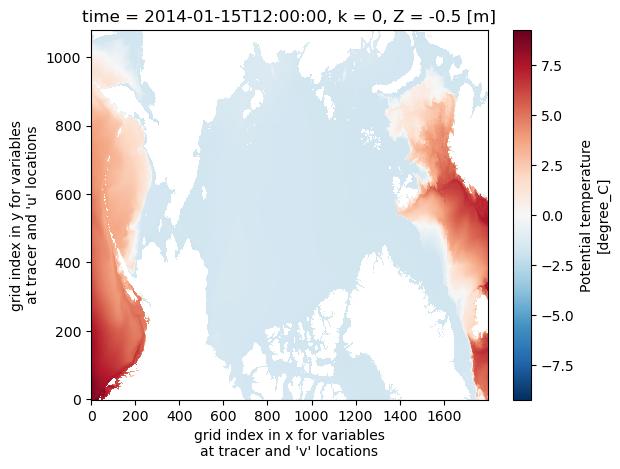

In [66]:
tmp.THETA.isel(time=0, k=0).plot()

In [68]:
## look at example dataset
tmp = xr.open_dataset("/Users/mzahn/data/SASSIE/SASSIE_netcdfs/ocean_state_3D_day_mean/SALT_AVG_DAILY/SALT_day_mean_2014-01-15_ECCO_SASSIE_V1_HH_llc1080.nc")

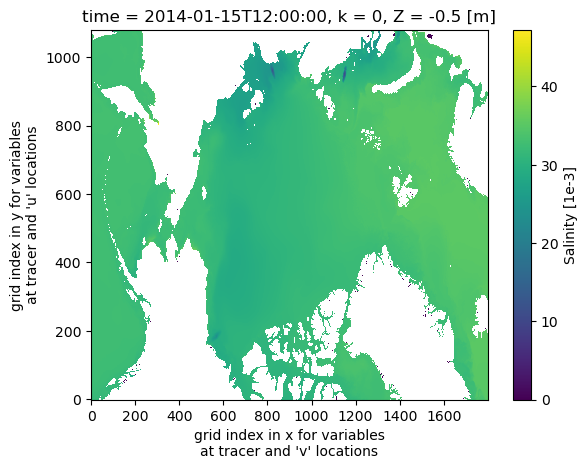

In [70]:
tmp.SALT.isel(time=0, k=0).plot()